In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import FormatStrFormatter

# import seaborn as sns

In [2]:
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0,
    'pdf.fonttype': 42
}
pylab.rcParams.update(params)

In [3]:
def plot_csv(
    ax, csv_file, kernel_configs, sketch_configs,
    target='p_opt',
    regression=False, y_lim=None,
    logscale=False, title='dataset',
    x_axis=True, ylabel='',
    ylog=False, plot_full_kernel=False
):
    
    bar_positions = []
    data_names = []
    
    #d_in = int(csv_file.split('_')[-2][1:])
    d_in = int(csv_file.split('/')[-1].split('_')[1][1:])
        
    df = pd.read_csv(csv_file)

    seeds = df['seed'].unique()

    bar_positions = np.arange(len(kernel_configs))
    width = 1./(len(sketch_configs)+1)
    
    for j, (name, config) in enumerate(sketch_configs):
        
        df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
        df_sel = df_sel[(df_sel['comp'] == config['complex'])]
        df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
        df_sel['p_opt'] = df_sel['feature_dist'].apply(lambda x: len(eval(x)))

        means = []
        stds = []
        for kernel_conf in kernel_configs:
            df_subsel = df_sel[
                (df_sel['kernel'] == kernel_conf[1]['kernel']) & (df_sel['degree'] == kernel_conf[1]['degree'])
            ]
            means.append(df_subsel[target].mean())
            stds.append(df_subsel[target].std())
        
        ax.bar(
            bar_positions + j*width, means,
            yerr=stds,
            error_kw=dict(lw=2, capsize=2, capthick=2, alpha=0.3),
            color=config['color'],
            width=width,
            label=name,
            align='edge'
        )
    
    ax.set_xticks(
        bar_positions+len(sketch_configs)*width/2.,
        labels=[config[0] for config in kernel_configs]
    )
    if not x_axis:
        ax.set_xticklabels([])

    if logscale:
        ax.set_yscale('log')

    if ylabel != '':
        ax.set_ylabel(ylabel)
        
    if y_lim is not None:
        ax.set_ylim(y_lim)
        
    if ylog:
        ax.set_yscale('log')
        
    ax.set_title(title)

In [4]:
colors = plt.get_cmap('tab20')(np.linspace(0, 1.0, 20))
colors = np.flip(colors, axis=0)

In [5]:
sketch_configs = [
    ('Opt. Maclaurin Rademacher', {'method': 'maclaurin', 'proj': 'rademacher', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[13]}),
    ('Opt. Complex Maclaurin Rademacher', {'method': 'maclaurin', 'proj': 'rademacher', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[14]}),
    ('Opt. Maclaurin TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'ahle': False, 'comp_real': False, 'color': colors[15]}),
    ('Opt. Complex Maclaurin TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'ahle': False, 'comp_real': False, 'color': colors[16]}),
]

## p*

In [6]:
kernel_configs = [
    ('p=3', {'kernel': 'polynomial', 'degree': 3}),
    ('p=7', {'kernel': 'polynomial', 'degree': 7}),
    ('p=10', {'kernel': 'polynomial', 'degree': 10}),
    ('p=20', {'kernel': 'polynomial', 'degree': 20}),
    ('Gaussian', {'kernel': 'gaussian', 'degree': 0})
]

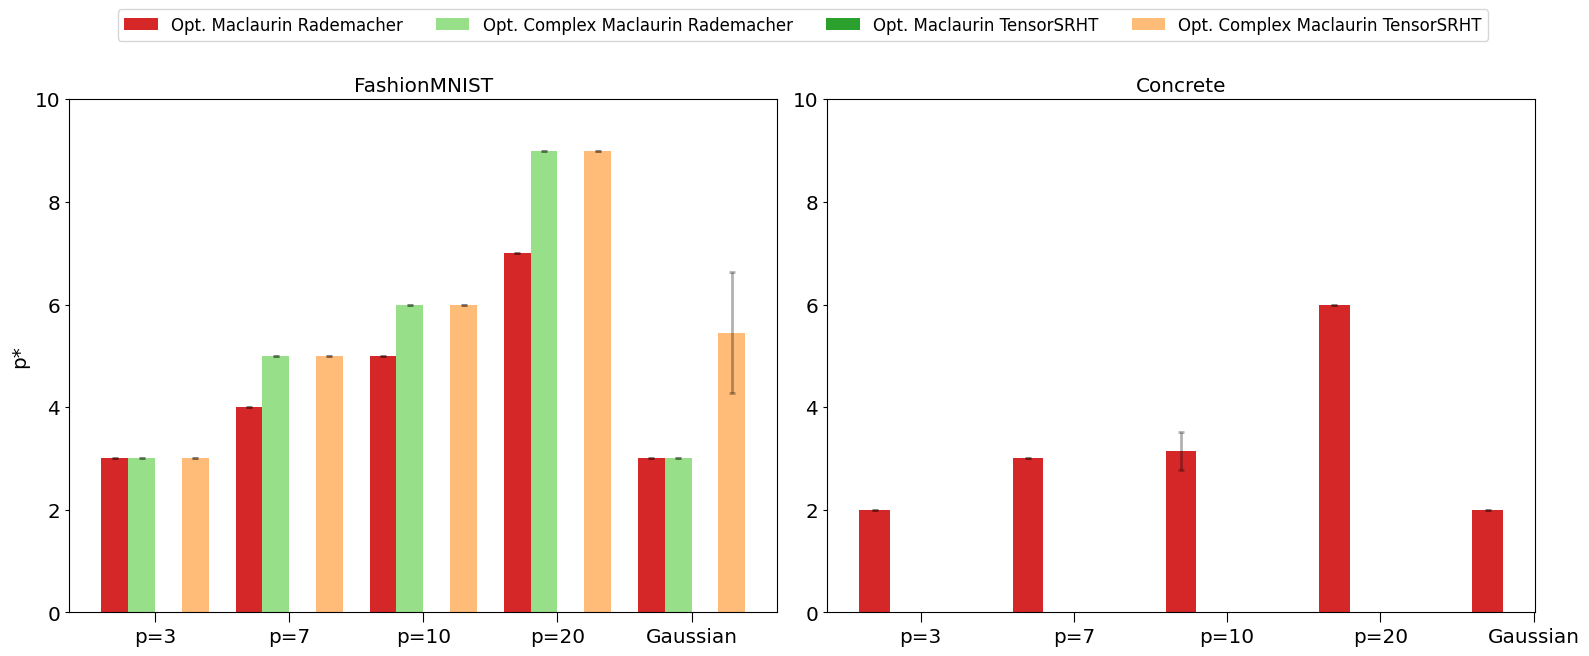

In [122]:
csv_files = [
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/p_opt_comparison/Concrete_d8_n1030_centering_True.csv',
    #'../csv/p_opt_comparison/kin8nm_d8_n8192_centering_True.csv'
]

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

for i, csv in enumerate(csv_files):
    name = csv.split('/')[-1].split('_')[0]

    ylabel='p*' if i==0 else ''
    plot_csv(axes[i], csv_files[i], kernel_configs, sketch_configs, logscale=False, title=f'{name}', x_axis=True, ylabel=ylabel, y_lim=(0,10))

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

In [ ]:
# p_max was set to 20 here => p* is always much lower!
# do: f_mnist 1k, 3k, 5k samples = 3 plots

## Distribution time

In [123]:
kernel_configs = [
    ('p=3', {'kernel': 'polynomial', 'degree': 3}),
    ('p=7', {'kernel': 'polynomial', 'degree': 7}),
    ('p=10', {'kernel': 'polynomial', 'degree': 10}),
    ('p=20', {'kernel': 'polynomial', 'degree': 20}),
]

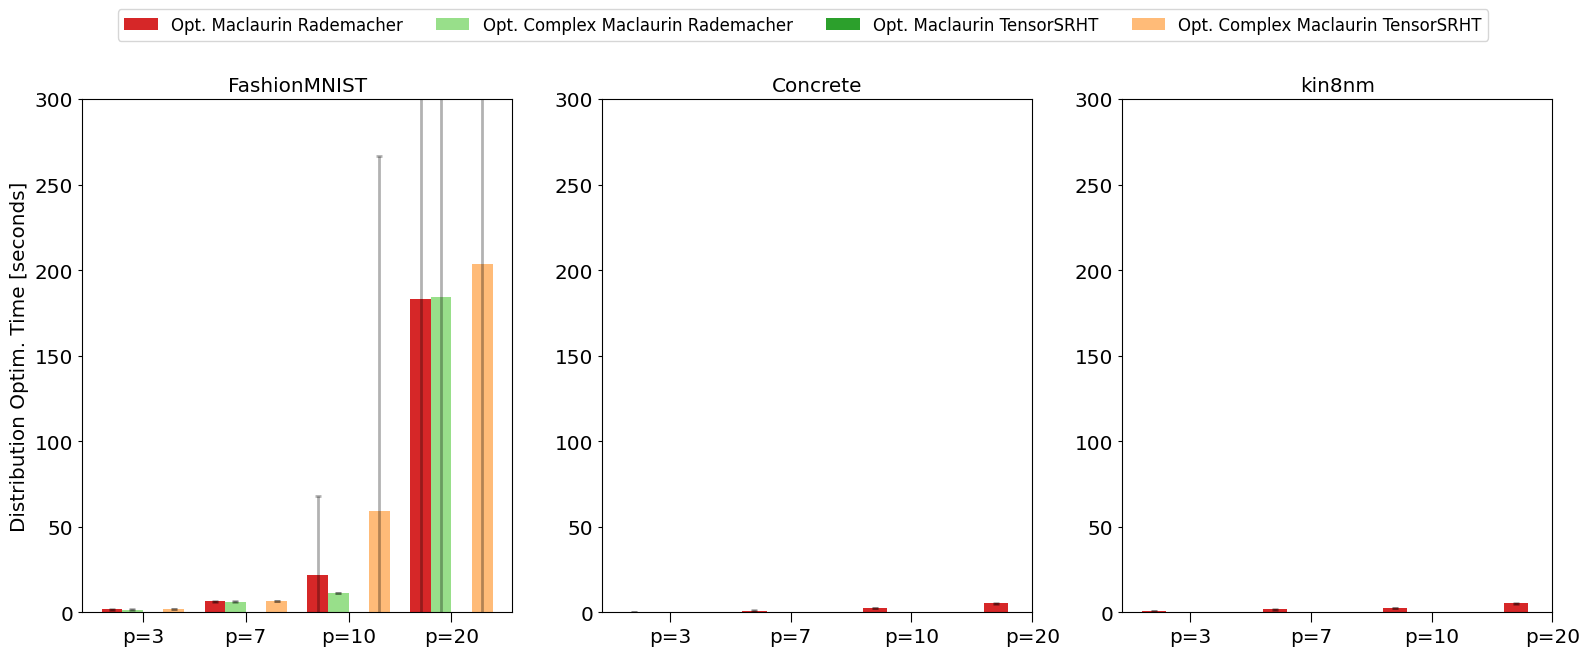

In [130]:
csv_files = [
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True.csv',
    '../csv/p_opt_comparison/Concrete_d8_n1030_centering_True.csv',
    '../csv/p_opt_comparison/kin8nm_d8_n8192_centering_True.csv'
]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 6))

for i, csv in enumerate(csv_files):
    name = csv.split('/')[-1].split('_')[0]

    ylabel='Distribution Optim. Time [seconds]' if i==0 else ''
    plot_csv(axes[i], csv_files[i], kernel_configs, sketch_configs, target='maclaurin_time', logscale=False, title=f'{name}', x_axis=True, ylabel=ylabel, y_lim=(0,300))

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=4, bbox_to_anchor = (0,0.25,1.01,0.85), bbox_transform=plt.gcf().transFigure)
# plt.savefig('../figures/mnist_cifar10_big.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight') # 
plt.show()

In [ ]:
# DO: p_max = 3,7,10,20 on x-axis, f_mnist 1k, 3k, 5k samples = 3 plots

### 1000 sample histogram

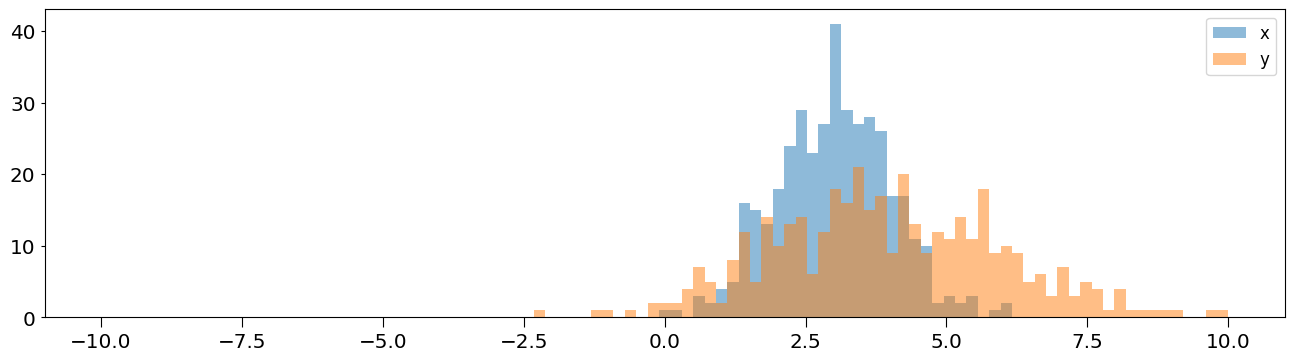

In [7]:
x = [np.random.normal(3,1) for _ in range(400)]
y = [np.random.normal(4,2) for _ in range(400)]

bins = np.linspace(-10, 10, 100)

plt.hist(x, bins, alpha=0.5, label='x')
plt.hist(y, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

In [32]:
degree_dist

0     3
4     3
8     3
12    3
16    3
20    3
24    3
28    3
32    3
36    3
40    3
44    3
48    3
52    3
56    3
60    3
64    3
68    3
72    3
76    3
Name: feature_dist, dtype: int64

In [33]:
degree_dist.values

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

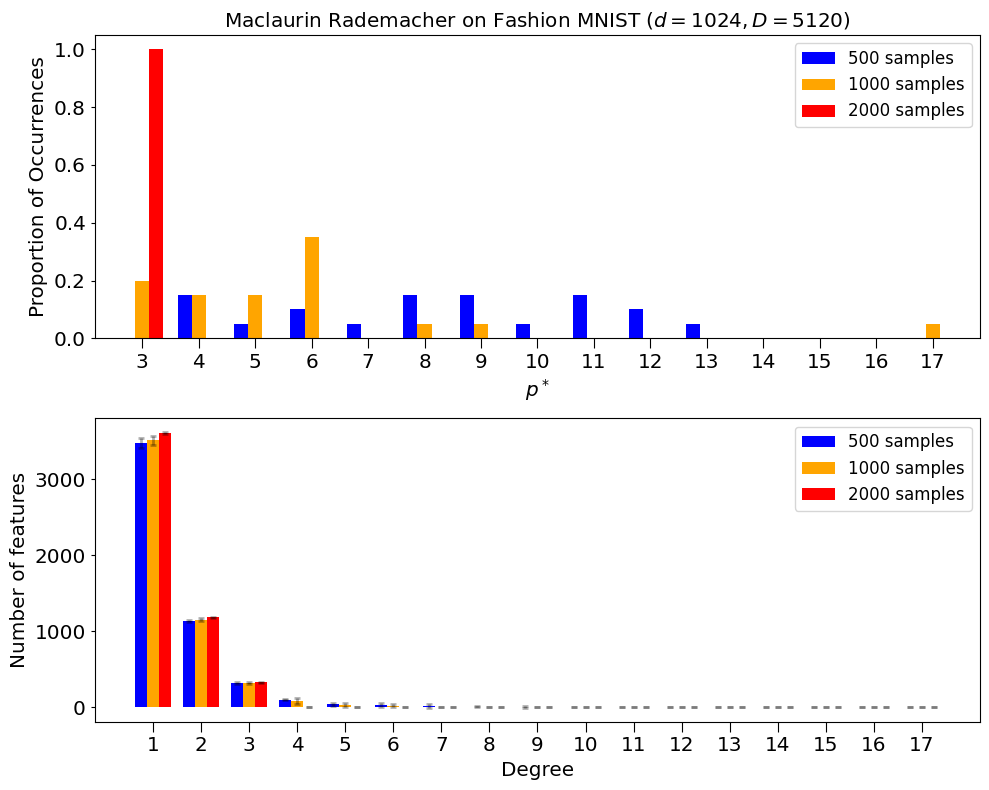

In [17]:
files = [
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_500.csv',
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_1000.csv',
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_2000.csv',
    # '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_3000.csv'
]
colors=['blue', 'orange', 'red', 'purple']
labels=['500 samples', '1000 samples', '2000 samples', '3000 samples']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

width = 1./(len(files)+1)

degrees = []

for j, file in enumerate(files):
    df = pd.read_csv(file)
    config = sketch_configs[0][1]
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['comp'] == config['complex'])]
    df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
    df_sel = df_sel[(df_sel['kernel'] == 'gaussian')]
    degree_dist = df_sel['feature_dist'].apply(lambda x: len(eval(x))).value_counts()

    bar_positions = degree_dist.index
    degrees = degrees + list(bar_positions)
    degrees = list(set(degrees))
    
    axes[0].bar(
        bar_positions + j*width, degree_dist.values / degree_dist.values.sum(),
        #yerr=stds,
        error_kw=dict(lw=2, capsize=2, capthick=2, alpha=0.3),
        color=colors[j],
        width=width,
        label=labels[j],
        align='edge'
    )
    
axes[0].set_xticks(
    np.arange(np.min(degrees), np.max(degrees)+1)+len(files)*width/2.,
    labels=np.arange(np.min(degrees), np.max(degrees)+1)
)
axes[0].set_xlabel(r'$p^*$')
axes[0].set_ylabel('Proportion of Occurrences')
axes[0].set_title('Maclaurin Rademacher on Fashion MNIST ($d=1024, D=5120$)')
axes[0].legend()

n_degrees = 17

bar_positions = np.arange(n_degrees)
width = 1./(len(files)+1)

for j, file in enumerate(files):
    df = pd.read_csv(file)
    config = sketch_configs[0][1]
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['comp'] == config['complex'])]
    df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
    df_sel = df_sel[(df_sel['kernel'] == 'gaussian')]
    degree_dist = df_sel['feature_dist'].apply(lambda x: len(eval(x)))

    feature_dists = [eval(dist) for dist in df_sel['feature_dist'].values]
    for dist in feature_dists:
        if len(dist) < n_degrees:
            dist += [0]*(n_degrees - len(dist))

    feature_dists = np.array(feature_dists)

    means = feature_dists.mean(axis=0)
    stds = feature_dists.std(axis=0)

    axes[1].bar(
        bar_positions + j*width, means,
        yerr=stds,
        error_kw=dict(lw=2, capsize=2, capthick=2, alpha=0.3),
        color=colors[j],
        width=width,
        label=labels[j],
        align='edge'
    )
    
axes[1].set_xticks(
    bar_positions+len(files)*width/2.,
    labels=np.arange(n_degrees)+1
)

axes[1].set_ylabel('Number of features')
axes[1].set_xlabel('Degree')
# axes[1].set_title(r'Fashion MNIST ($D=5120$)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../figures/dp_opt_comparison_fmnist_rademacher.pdf', dpi=300)
plt.show()

In [57]:
5*64

320

In [9]:
sketch_configs

[('Opt. Maclaurin Rademacher',
  {'method': 'maclaurin',
   'proj': 'rademacher',
   'complex': False,
   'ahle': False,
   'comp_real': False,
   'color': array([0.83921569, 0.15294118, 0.15686275, 1.        ])}),
 ('Opt. Complex Maclaurin Rademacher',
  {'method': 'maclaurin',
   'proj': 'rademacher',
   'complex': True,
   'ahle': False,
   'comp_real': False,
   'color': array([0.59607843, 0.8745098 , 0.54117647, 1.        ])}),
 ('Opt. Maclaurin TensorSRHT',
  {'method': 'maclaurin',
   'proj': 'srht',
   'complex': False,
   'ahle': False,
   'comp_real': False,
   'color': array([0.17254902, 0.62745098, 0.17254902, 1.        ])}),
 ('Opt. Complex Maclaurin TensorSRHT',
  {'method': 'maclaurin',
   'proj': 'srht',
   'complex': True,
   'ahle': False,
   'comp_real': False,
   'color': array([1.        , 0.73333333, 0.47058824, 1.        ])})]

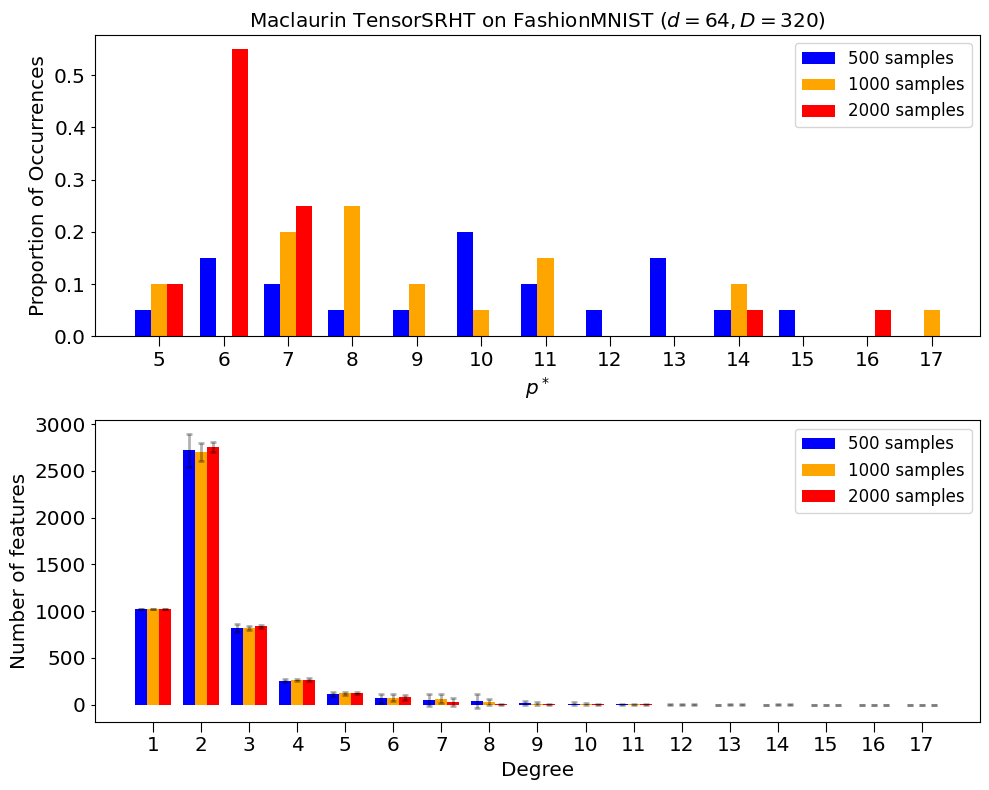

In [18]:
files = [
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_500.csv',
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_1000.csv',
    '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_2000.csv',
    # '../csv/p_opt_comparison/FashionMNIST_d1024_n70000_centering_True_samples_3000.csv'
]
colors=['blue', 'orange', 'red', 'purple']
labels=['500 samples', '1000 samples', '2000 samples', '3000 samples']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

width = 1./(len(files)+1)

degrees = []

for j, file in enumerate(files):
    df = pd.read_csv(file)
    config = sketch_configs[2][1]
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['comp'] == config['complex'])]
    df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
    df_sel = df_sel[(df_sel['kernel'] == 'gaussian')]
    degree_dist = df_sel['feature_dist'].apply(lambda x: len(eval(x))).value_counts()

    bar_positions = degree_dist.index
    degrees = degrees + list(bar_positions)
    degrees = list(set(degrees))
    
    axes[0].bar(
        bar_positions + j*width, degree_dist.values / degree_dist.values.sum(),
        #yerr=stds,
        error_kw=dict(lw=2, capsize=2, capthick=2, alpha=0.3),
        color=colors[j],
        width=width,
        label=labels[j],
        align='edge'
    )
    
axes[0].set_xticks(
    np.arange(np.min(degrees), np.max(degrees)+1)+len(files)*width/2.,
    labels=np.arange(np.min(degrees), np.max(degrees)+1)
)
axes[0].set_xlabel(r'$p^*$')
axes[0].set_ylabel('Proportion of Occurrences')
axes[0].set_title('Maclaurin TensorSRHT on FashionMNIST ($d=64, D=320$)')
axes[0].legend()

n_degrees = 17

bar_positions = np.arange(n_degrees)
width = 1./(len(files)+1)

for j, file in enumerate(files):
    df = pd.read_csv(file)
    config = sketch_configs[2][1]
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['comp'] == config['complex'])]
    df_sel = df_sel[(df_sel['ahle'] == config['ahle'])]
    df_sel = df_sel[(df_sel['kernel'] == 'gaussian')]
    degree_dist = df_sel['feature_dist'].apply(lambda x: len(eval(x)))

    feature_dists = [eval(dist) for dist in df_sel['feature_dist'].values]
    for dist in feature_dists:
        if len(dist) < n_degrees:
            dist += [0]*(n_degrees - len(dist))

    feature_dists = np.array(feature_dists)

    means = feature_dists.mean(axis=0)
    stds = feature_dists.std(axis=0)

    axes[1].bar(
        bar_positions + j*width, means,
        yerr=stds,
        error_kw=dict(lw=2, capsize=2, capthick=2, alpha=0.3),
        color=colors[j],
        width=width,
        label=labels[j],
        align='edge'
    )
    
axes[1].set_xticks(
    bar_positions+len(files)*width/2.,
    labels=np.arange(n_degrees)+1
)

axes[1].set_ylabel('Number of features')
axes[1].set_xlabel('Degree')
# axes[1].set_title(r'Fashion MNIST ($D=5120$)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../figures/dp_opt_comparison_fmnist_srht.pdf', dpi=300)
plt.show()

In [ ]:
# Time complexity discussion:
# - p in (pmin, pmax): run incremental (p x D_total complexity)
# => O(pmax^2 D_total) + p m^2 -> less than Johnson Lindenstrauss Projection O(ndD)